In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

from datasets import load_dataset
import torch as t
from nnsight import LanguageModel
from tqdm import tqdm
from collections import defaultdict

from buffer import AllActivationBuffer
from trainers.scae import SCAESuite
from utils import load_model_with_folded_ln2, load_iterable_dataset

DTYPE = t.bfloat16
device = "cuda:0" if t.cuda.is_available() else "cpu"
model = load_model_with_folded_ln2("gpt2", device=device, torch_dtype=DTYPE)

data = load_iterable_dataset('Skylion007/openwebtext')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
C = 10
expansion = 16
k = 128

num_features = model.config.n_embd * expansion
n_layer = model.config.n_layer

In [10]:
pretrained_configs = {}
connections = defaultdict(dict)

for down_layer in range(n_layer):
    for module in ['attn', 'mlp']:
        down_name = f'{module}_{down_layer}'
        pretrained_configs[f'{module}_{down_layer}'] = {
            'repo_id': 'jacobcd52/scae', 
            'filename': f'ae_{module}_{down_layer}.pt',
            'k' : k,
            }
        
        # Use random connections for testing
        if module=='mlp':
            for up_layer in range(down_layer+1):
                up_name = f'{module}_{up_layer}'
                connections[down_name][up_name] = t.randint(0, num_features, (num_features, C), dtype=t.long)

suite = SCAESuite.from_pretrained(
    pretrained_configs, 
    connections=connections,
    dtype=DTYPE,
    )

/root/dictionary_learning/notebooks/../trainers/scae.py:594: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(weights_path, map_location='cpu')


In [11]:
initial_submodule = model.transformer.h[0]
submodules = {}
for layer in range(n_layer):
    submodules[f"mlp_{layer}"] = (model.transformer.h[layer].mlp, "in_and_out")
    submodules[f"attn_{layer}"] = (model.transformer.h[layer].attn, "out")

buffer = AllActivationBuffer(
    data=data,
    model=model,
    submodules=submodules,
    initial_submodule=initial_submodule,
    d_submodule=model.config.n_embd,
    n_ctxs=128,
    out_batch_size = 32,
    refresh_batch_size = 256,
    device=device,
    dtype=DTYPE,
)

/root/dictionary_learning/notebooks/../buffer.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t.cuda.amp.autocast(dtype=self.dtype):


In [30]:
norms = []
for i in tqdm(range(10_000)):
    a, b, c = next(buffer)
    if i % 20 == 0:
        norms.append(b['mlp_4'][:,0].mean().item())

  1%|          | 81/10000 [00:00<00:12, 803.83it/s]

  5%|▌         | 534/10000 [00:00<00:10, 899.15it/s]/root/dictionary_learning/notebooks/../buffer.py:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t.cuda.amp.autocast(dtype=self.dtype):
100%|██████████| 10000/10000 [00:14<00:00, 699.32it/s]


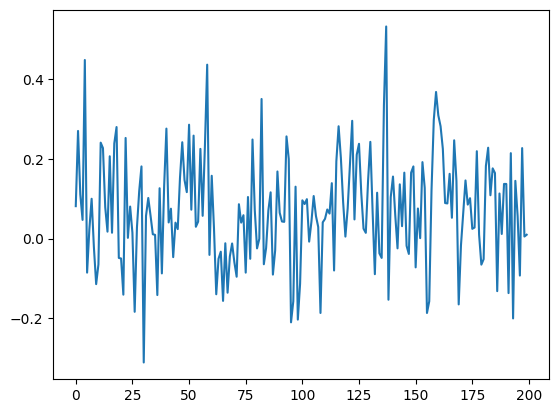

: 

: 

In [31]:
import matplotlib.pyplot as plt
plt.plot(norms[:200])

In [15]:
def run_evaluation(
        suite, 
        buffer, 
        n_batches=10, 
        ce_batch_size=32,
        use_sparse_connections=False
        ):
    '''Simple function to run evaluation on several batches, and return the average metrics'''
    
    varexp_metrics = {name : {} for name in buffer.submodules.keys()}
    ce_metrics = {name : {} for name in buffer.submodules.keys()}

    for i in tqdm(range(n_batches)):
        # get varexp metrics
        initial_acts, input_acts, output_acts = next(buffer)
        batch_varexp_metrics = suite.evaluate_varexp_batch(
            initial_acts,
            input_acts, 
            output_acts,
            use_sparse_connections=use_sparse_connections
            )

        # get CE metrics
        b = buffer.refresh_batch_size
        buffer.refresh_batch_size = ce_batch_size
        tokens = buffer.token_batch()
        batch_ce_metrics = suite.evaluate_ce_batch(
            model, 
            tokens, 
            initial_submodule,
            submodules,
            use_sparse_connections=use_sparse_connections
            )
        buffer.refresh_batch_size = b

        for name in ce_metrics.keys():
            for metric in batch_ce_metrics[name].keys():
                ce_metrics[name][metric] = ce_metrics[name].get(metric, 0) + batch_ce_metrics[name].get(metric, 0) / n_batches
            for metric in batch_varexp_metrics[name].keys():
                varexp_metrics[name][metric] = varexp_metrics[name].get(metric, 0) + batch_varexp_metrics[name].get(metric, 0) / n_batches
           
    return varexp_metrics, ce_metrics

In [16]:
varexp_metrics, ce_metrics = run_evaluation(
    suite, 
    buffer, 
    n_batches=10, 
    ce_batch_size=32,
    use_sparse_connections=False
    )

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


In [17]:
print(f"Clean loss = {ce_metrics['mlp_0']['loss_original']:.3f}\n")

print("Module  CE increase  CE expl Var expl")
for name in [k for k in ce_metrics.keys() if 'mlp' in k]:
    print(f"{name}   {ce_metrics[name]['loss_reconstructed'] - ce_metrics[name]['loss_original']:.3f}        {ce_metrics[name]['frac_recovered']*100:.0f}%     {varexp_metrics[name]['frac_variance_explained']*100:.0f}%")

print()

for name in [k for k in ce_metrics.keys() if 'attn' in k]:
    print(f"{name}   {ce_metrics[name]['loss_reconstructed'] - ce_metrics[name]['loss_original']:.3f}        {ce_metrics[name]['frac_recovered']*100:.0f}%     {varexp_metrics[name]['frac_variance_explained']*100:.0f}%")

Clean loss = 3.367

Module  CE increase  CE expl Var expl
mlp_0   7.008        -58%     -4060%
mlp_1   4.664        -9558%     -8425%
mlp_2   3.439        -6135%     -17048%
mlp_3   4.939        -8014%     -6369%
mlp_4   5.902        -9587%     -7635%
mlp_5   3.123        -4031%     -5255%
mlp_6   3.264        -3680%     -5242%
mlp_7   2.983        -3332%     -8225%
mlp_8   3.114        -3275%     -8290%
mlp_9   2.220        -2006%     -9300%
mlp_10   3.098        -2274%     -9740%
mlp_11   3.330        -1536%     -1674%

attn_0   0.006        100%     99%
attn_1   -0.002        110%     97%
attn_2   0.000        103%     96%
attn_3   -0.002        107%     93%
attn_4   0.003        93%     92%
attn_5   0.000        101%     93%
attn_6   0.002        98%     92%
attn_7   0.002        98%     93%
attn_8   0.000        102%     92%
attn_9   -0.002        103%     93%
attn_10   0.003        94%     94%
attn_11   0.000        100%     99%
